## IMDB text classification

In [128]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0


### Getting IMDB dataset

In [129]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

### Let's see what we got

In [130]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [131]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews have different lengths

In [132]:
len(train_data[0]), len(train_data[1])

(218, 189)

Let's get the words for these integers

In [133]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [134]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### Let's prepare the data

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

- One-hot-encode the arrays to convert them into vectors of 0s and 1s. For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a num_words * num_reviews size matrix.
- Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape num_examples * max_length. We can use an embedding layer capable of handling this shape as the first layer in our network.

In this tutorial, we will use the second approach.

Since the movie reviews must be the same length, we will use the pad_sequences function to standardize the lengths:

In [135]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [136]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [137]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### Build the model

The neural network is created by stacking layers—this requires two main architectural decisions:

- How many layers to use in the model?
- How many hidden units to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a model for this problem:

In [138]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model can handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

#### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called overfitting, and we'll explore it later.

#### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs of a probability (a single-unit layer with a sigmoid activation), we'll use the binary_crossentropy loss function.

This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, binary_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [139]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Validation Set

In [140]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [141]:
print(len(train_data))
print(len(x_val))

25000
10000


### Train the model

Train the model for 20 epochs in mini-batches of 512 samples. This is 20 iterations over all samples in the x_train and y_train tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [142]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 2s 107us/step - loss: 0.6918 - acc: 0.5434 - val_loss: 0.6896 - val_acc: 0.6219
Epoch 2/40
15000/15000 [==============================] - 1s 80us/step - loss: 0.6850 - acc: 0.7277 - val_loss: 0.6800 - val_acc: 0.7558
Epoch 3/40
15000/15000 [==============================] - 1s 76us/step - loss: 0.6700 - acc: 0.7699 - val_loss: 0.6611 - val_acc: 0.7620
Epoch 4/40
15000/15000 [==============================] - 1s 80us/step - loss: 0.6432 - acc: 0.7803 - val_loss: 0.6310 - val_acc: 0.7711
Epoch 5/40
15000/15000 [==============================] - 1s 83us/step - loss: 0.6032 - acc: 0.8034 - val_loss: 0.5887 - val_acc: 0.7924
Epoch 6/40
15000/15000 [==============================] - 1s 67us/step - loss: 0.5540 - acc: 0.8221 - val_loss: 0.5420 - val_acc: 0.8085
Epoch 7/40
15000/15000 [==============================] - 1s 68us/step - loss: 0.5013 - acc: 0.8405 - val_loss: 0.4949 - val_ac

### Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [143]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 46us/step
[0.3462004272413254, 0.87156]


In [144]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])

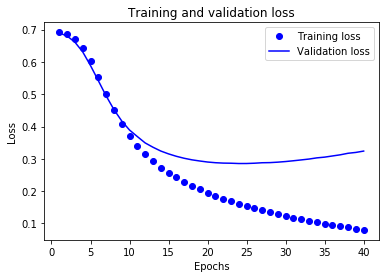

In [145]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()




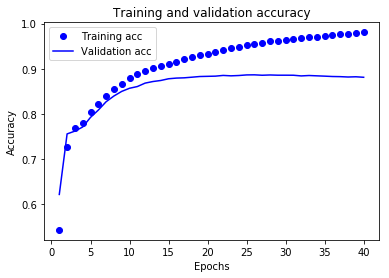

In [146]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

In [ ]:
rand_review = np.random.randint(10000, size=256)
biased_review = np.full(256, 530)
test_data = np.append(test_data, [rand_review], axis=0)
test_data = np.append(test_data, [biased_review], axis=0)

In [127]:

    
#print(model.predict(test_data))
asd = model.predict(test_data)
asd.shape

#print(decode_review(test_data[-2]))
#print(decode_review(test_data[-1]))

(25016, 1)

In [126]:
test_data.shape

(25014, 256)

In [117]:
decode_review(test_data[25000])

"comments plant hollywood arrest cinema little jumping examples ajay name thought local argue wanting opportunities instinct ny politics wilderness audiences conquest talentless anything brides prove kaufman apartheid star martian dancer appeal scariest walter troubles mccoy allegory parts gus louise cheerful delicious core details thirties loses oppressive mirrors rochester ghost poetry frankie desert excitement results meet jessie neglected phenomenon hiding stealth gentlemen 700 follows tasks submit jedi documentaries correctly carradine gender assured sketch antonioni difference successful hiring mormon redeeming adventurous sketches heist waving jail bulk slept deputy returning intestines attack administration removed ostensibly slaves masterson chose cody peculiar superstar directorial track ear harold apparently anne 200 incorrect fades tries spoof visits trusted advice realm cheap snl disliked perspective bow idiot coop egypt controlled virtues psychotic notion grainy fog small

In [118]:
test_data.shape

(25002, 256)